In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(
    style="whitegrid",
    font_scale=2
);


In [2]:
DATA_FOLDER = Path('./data')
FRAME_LENGTH = 30
classes = [f.name for f in DATA_FOLDER.iterdir()]
classes

['running', 'stairs', 'walking', 'idle']

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [4]:
x_acc_cols = [f'acc_x_{i}' for i in range(FRAME_LENGTH)]
y_acc_cols = [f'acc_y_{i}' for i in range(FRAME_LENGTH)]
z_acc_cols = [f'acc_z_{i}' for i in range(FRAME_LENGTH)]

In [260]:
frames = []
labels = []

for class_name in classes:
    class_folder = DATA_FOLDER / class_name
    for file in class_folder.iterdir():
        df = pd.read_csv(file)
        flat_frame = np.hstack([df['accelerometer_X'], df['accelerometer_Y'], df['accelerometer_Z']]).astype(float)
        frames.append(flat_frame)
        labels.append(class_name)

In [261]:
raw_data = pd.DataFrame(frames, columns = x_acc_cols+y_acc_cols+z_acc_cols)
raw_data = pd.concat([raw_data, pd.Series(labels, name='label')], axis=1)

In [262]:
raw_data.head(3)

,acc_x_0,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,acc_x_9,...,acc_z_21,acc_z_22,acc_z_23,acc_z_24,acc_z_25,acc_z_26,acc_z_27,acc_z_28,acc_z_29,label
0,2.667141,4.017470,22.357056,17.922995,-2.164358,9.749189,3.303998,-3.275268,5.252879,21.490355,...,13.493721,-2.001553,16.668432,9.208099,-7.187393,12.430696,-8.939949,1.470040,10.807426,running
1,10.745177,3.744532,0.766145,23.956383,-0.454898,-3.481169,3.572149,7.527370,-10.793061,9.481039,...,11.468226,-0.952892,-0.943315,-0.416591,0.483629,0.363919,1.699883,3.390190,-1.407790,running
2,22.031445,3.600880,-0.354342,8.245631,18.641254,4.381389,26.499025,4.003105,3.284845,2.231396,...,0.565032,-4.079719,-3.677494,4.596867,-0.550666,-6.019023,-1.139640,-2.164358,-3.016694,running


# Setup CV

In [263]:
raw_data.shape

(6462, 91)

In [264]:
raw_data.label.value_counts()

running    3408
walking    1850
idle       1039
stairs      165
Name: label, dtype: int64

In [265]:
from sklearn.model_selection import StratifiedKFold

In [266]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [267]:
X = raw_data['acc_x_0']
y = raw_data['label']

for i, (_, valid_ix) in enumerate(kfold.split(X, y)):
    y_valid = y.loc[valid_ix]
    value_counts = y_valid.value_counts()
    print(f'split#{i}, we have {value_counts.stairs} stairs, {value_counts.running} running samples')
#     print(    (y_valid == 'stairs').index)

split#0, we have 33 stairs, 682 running samples
split#1, we have 33 stairs, 682 running samples
split#2, we have 33 stairs, 682 running samples
split#3, we have 33 stairs, 681 running samples
split#4, we have 33 stairs, 681 running samples


In [268]:
from sklearn import svm
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix

# 24 features

**A Study on Human Activity Recognition Using Accelerometer Data from Smartphones**

- mean_x, mean_y, mean_z
- MinMax_x, MinMax_y, MinMax_z
- std_x, std_y, std_z
- RMS_x, RMS_y, RMS_z
- corr_xy, corr_xz, corr_yz
- APF_x, APF_y, APF_z (average of peak frequency)
- VarAPF

In [269]:
feature_df = raw_data[['label']].copy()
feature_df['encoded_label'] = le.transform(feature_df['label'])

In [270]:
def gen_feature_mean(ts):
    return np.mean(ts, axis=1)

## mean 

In [271]:
feature_df['mean_x'] = gen_feature_mean(raw_data[x_acc_cols])
feature_df['mean_y'] = gen_feature_mean(raw_data[y_acc_cols])
feature_df['mean_z'] = gen_feature_mean(raw_data[z_acc_cols])
mean_features = ['mean_x', 'mean_y', 'mean_z']

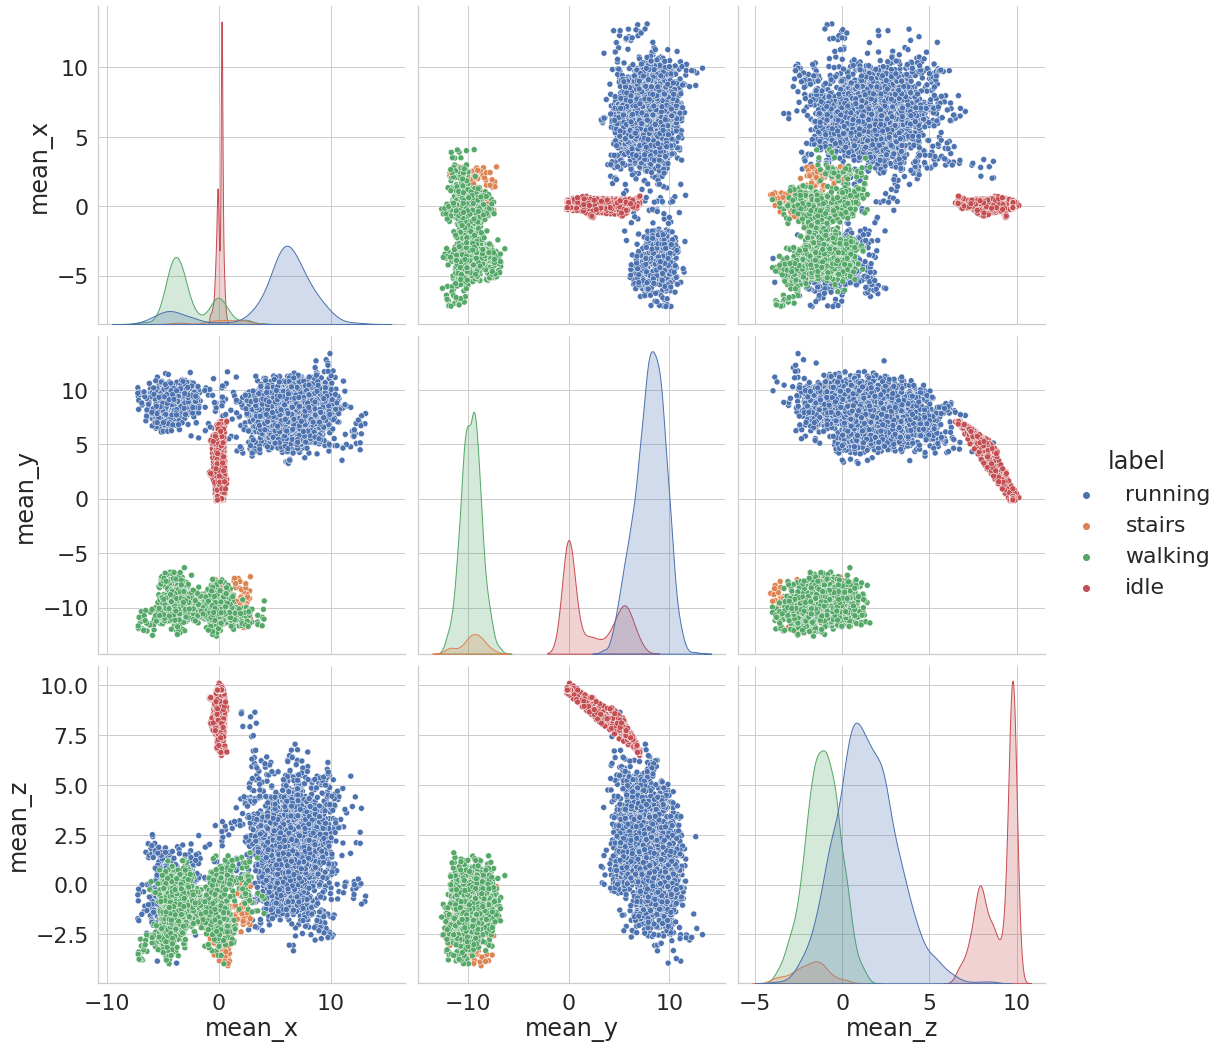

In [272]:
# plt.rcParams['figure.figsize'] = [16,8]
# plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
sns.pairplot(data=feature_df[mean_features + ['label']], hue='label', height=5);

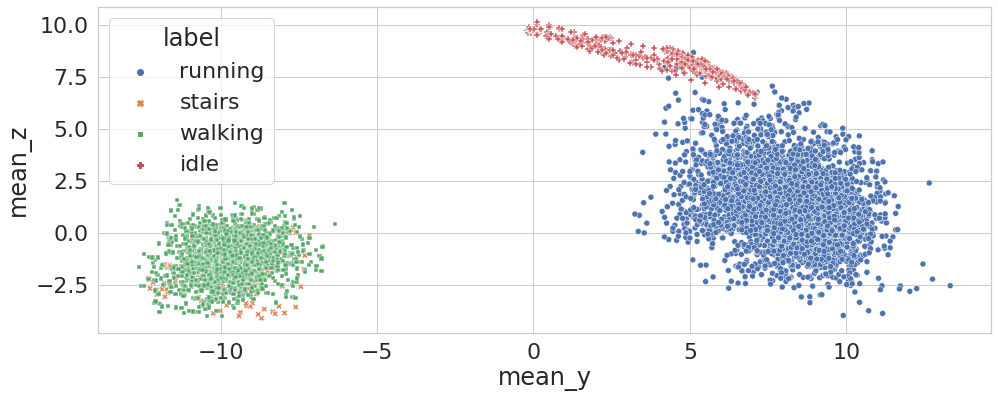

In [273]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=feature_df, x="mean_y", y="mean_z", hue="label", style="label")

In [274]:
X = feature_df[['mean_x', 'mean_y', 'mean_z']]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred, average=None).min())
#     print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

F1 score mean: 0.06, std: 0.1


## minmax_range

In [275]:
def gen_feature_minmax_range(ts):
    return np.max(ts, axis=1) - np.min(ts, axis=1)


In [276]:
feature_df['minmax_range_x'] = gen_feature_minmax_range(raw_data[x_acc_cols])
feature_df['minmax_range_y'] = gen_feature_minmax_range(raw_data[y_acc_cols])
feature_df['minmax_range_z'] = gen_feature_minmax_range(raw_data[z_acc_cols])
minmax_range_features = ['minmax_range_x', 'minmax_range_y', 'minmax_range_z']

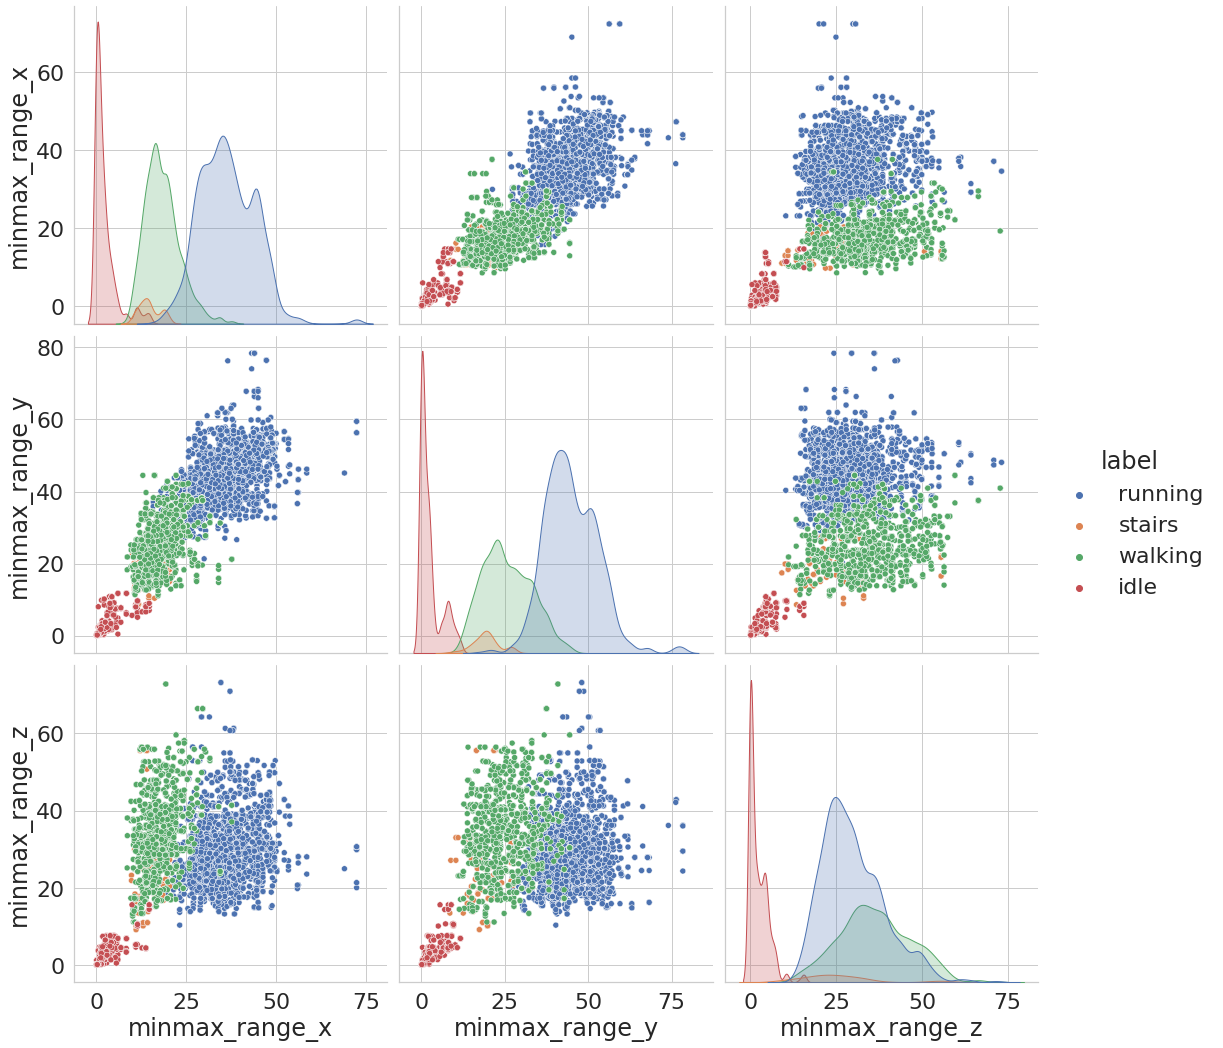

In [277]:
sns.pairplot(data=feature_df[minmax_range_features + ['label']], hue='label', height=5);

In [278]:
X = feature_df[['minmax_range_x', 'minmax_range_y', 'minmax_range_z']]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 667   0  15]
 [  1   0   0  32]
 [  0  14   0 356]]
[[208   0   0   0]
 [  0 670   0  12]
 [  0   0   0  33]
 [  1  11   0 358]]
[[207   0   0   0]
 [  0 671   0  11]
 [  0   0   0  33]
 [  0  23   0 347]]
[[208   0   0   0]
 [  0 670   0  11]
 [  0   0   0  33]
 [  0  17   0 353]]
[[208   0   0   0]
 [  0 669   0  12]
 [  0   0   0  33]
 [  1  17   0 352]]
F1 score mean: 0.0, std: 0.0


In [279]:
X = feature_df[['mean_x', 'mean_y', 'mean_z', 'minmax_range_x', 'minmax_range_y', 'minmax_range_z']]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
F1 score mean: 0.0, std: 0.0


In [280]:
from sklearn.linear_model import LogisticRegression

In [281]:
X = feature_df[['mean_x', 'mean_y', 'mean_z']]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=1_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  3 679   0   0]
 [  0   0  13  20]
 [  0   0   5 365]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  11  22]
 [  0   0   2 368]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  12  21]
 [  0   0   6 364]]
[[208   0   0   0]
 [  2 679   0   0]
 [  0   0  14  19]
 [  0   0  12 358]]
[[208   0   0   0]
 [  1 680   0   0]
 [  0   0  14  19]
 [  0   0   7 363]]
F1 score mean: 0.49, std: 0.02


In [282]:
X = feature_df[['mean_x', 'mean_y', 'mean_z', 'minmax_range_x', 'minmax_range_y', 'minmax_range_z']]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  18  15]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  23  10]
 [  0   0   6 364]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  22  11]
 [  0   0   4 366]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  18  15]
 [  0   0  12 358]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  23  10]
 [  0   0   6 364]]
F1 score mean: 0.69, std: 0.07


# Go to binary classification

In [283]:
raw_stairs_df = raw_data[raw_data['label'].isin(['stairs', 'walking'])].copy().reset_index(drop=True)
raw_stairs_df.head(2)

,acc_x_0,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,acc_x_9,...,acc_z_21,acc_z_22,acc_z_23,acc_z_24,acc_z_25,acc_z_26,acc_z_27,acc_z_28,acc_z_29,label
0,0.675165,-1.278504,-4.424484,0.646435,-1.623269,-4.323928,-5.228936,-3.088520,-3.021482,-11.238382,...,-13.517663,-0.263362,-1.795651,1.580173,-1.517924,-0.330400,-1.460463,9.255983,7.910443,stairs
1,2.264915,0.991200,2.226608,-1.647211,8.398860,2.494758,0.823605,-6.224924,1.273715,0.723049,...,-3.284845,-3.864241,-4.151545,0.636858,-2.585738,-2.202665,-2.456451,-0.933739,0.885855,stairs


In [284]:
stairs_df = feature_df[feature_df['label'].isin(['stairs', 'walking'])].copy().reset_index(drop=True)
stairs_df.head()

,label,encoded_label,mean_x,mean_y,mean_z,minmax_range_x,minmax_range_y,minmax_range_z
0,stairs,2,-3.484042,-8.297824,-0.513955,15.207968,19.924546,22.773646
1,stairs,2,0.457133,-8.333099,-3.764004,14.623784,10.390835,33.006464
2,stairs,2,2.487257,-11.696792,-1.645455,14.058752,21.763294,55.578997
3,stairs,2,1.993732,-8.358956,-0.573491,20.350714,16.558300,27.255591
4,stairs,2,-0.800940,-11.220506,-2.930503,18.564640,26.891676,26.580427


In [285]:
stairs_df['is_stairs'] = stairs_df['label'] == 'stairs'

In [286]:
X = stairs_df[mean_features + minmax_range_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[359  11]
 [  9  24]]
[[364   6]
 [ 10  23]]
[[362   8]
 [ 12  21]]
[[366   4]
 [ 16  17]]
[[365   5]
 [ 12  21]]
F1 score mean: 0.69, std: 0.04


In [287]:
X = stairs_df[mean_features + minmax_range_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[370   0]
 [ 32   1]]
[[370   0]
 [ 33   0]]
[[370   0]
 [ 31   2]]
[[370   0]
 [ 33   0]]
[[370   0]
 [ 33   0]]
F1 score mean: 0.03, std: 0.05


## std

In [288]:
def gen_feature_std(ts):
    return np.std(ts, axis=1)

In [289]:
stairs_df['std_x'] = gen_feature_std(raw_stairs_df[x_acc_cols])
stairs_df['std_y'] = gen_feature_std(raw_stairs_df[y_acc_cols])
stairs_df['std_z'] = gen_feature_std(raw_stairs_df[z_acc_cols])

In [290]:
std_features = ['std_x', 'std_y', 'std_z']

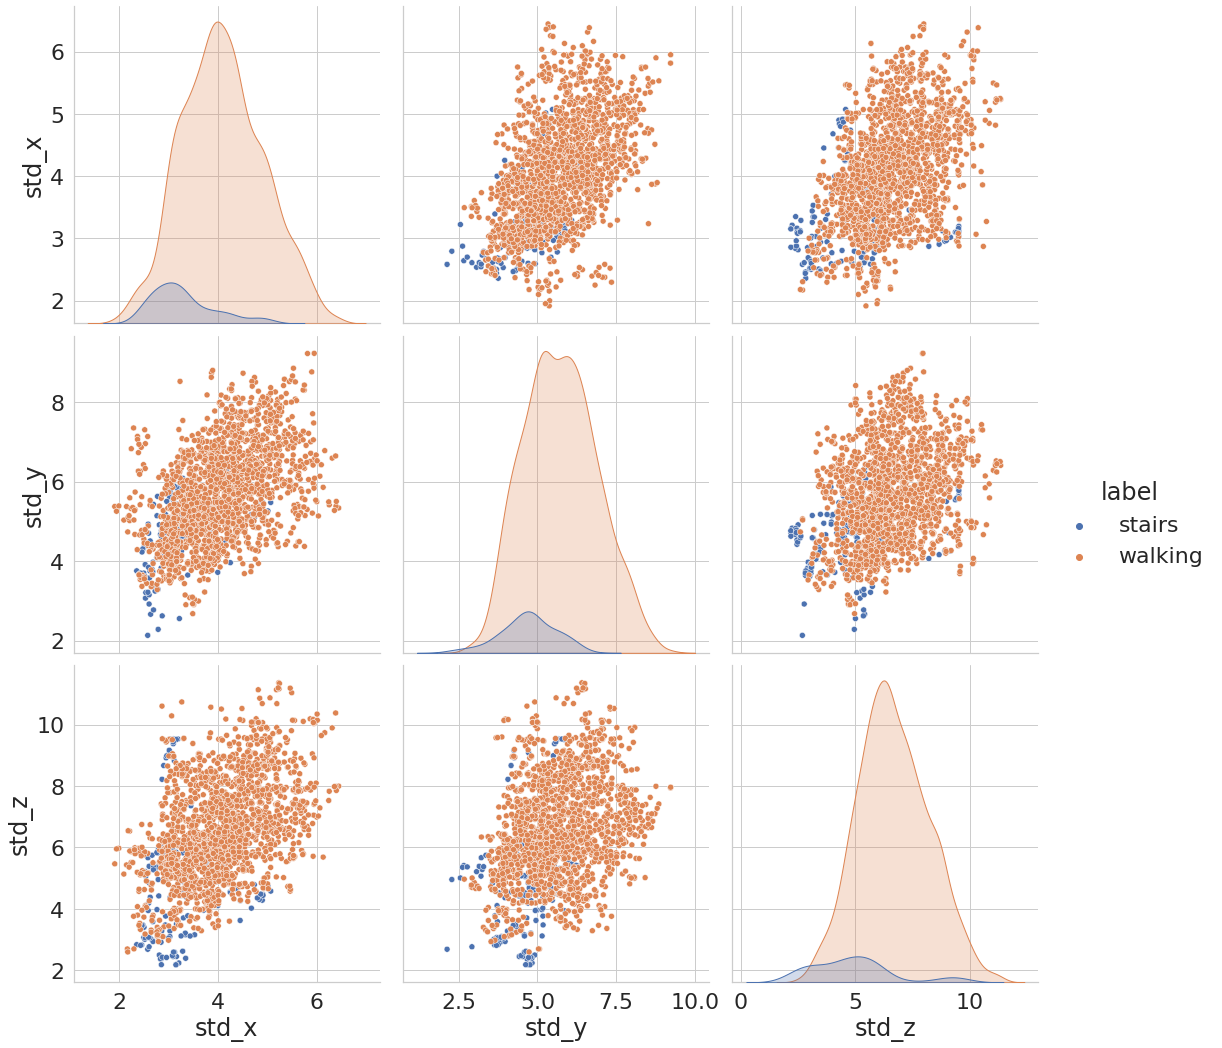

In [291]:
# plt.rcParams['figure.figsize'] = [16,8]
# plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
sns.pairplot(data=stairs_df[std_features + ['label']], hue='label', height=5);

In [292]:
X = stairs_df[mean_features + minmax_range_features + std_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[360  10]
 [  8  25]]
[[365   5]
 [  8  25]]
[[364   6]
 [ 13  20]]
[[367   3]
 [ 16  17]]
[[364   6]
 [ 12  21]]
F1 score mean: 0.71, std: 0.05


## RMS

In [293]:
def gen_feature_rms(ts):
    return np.sqrt(np.mean(np.square(ts), axis=1))

In [294]:
stairs_df['rms_x'] = gen_feature_rms(raw_stairs_df[x_acc_cols])
stairs_df['rms_y'] = gen_feature_rms(raw_stairs_df[y_acc_cols])
stairs_df['rms_z'] = gen_feature_rms(raw_stairs_df[z_acc_cols])

rms_features = ['rms_x', 'rms_y', 'rms_z']

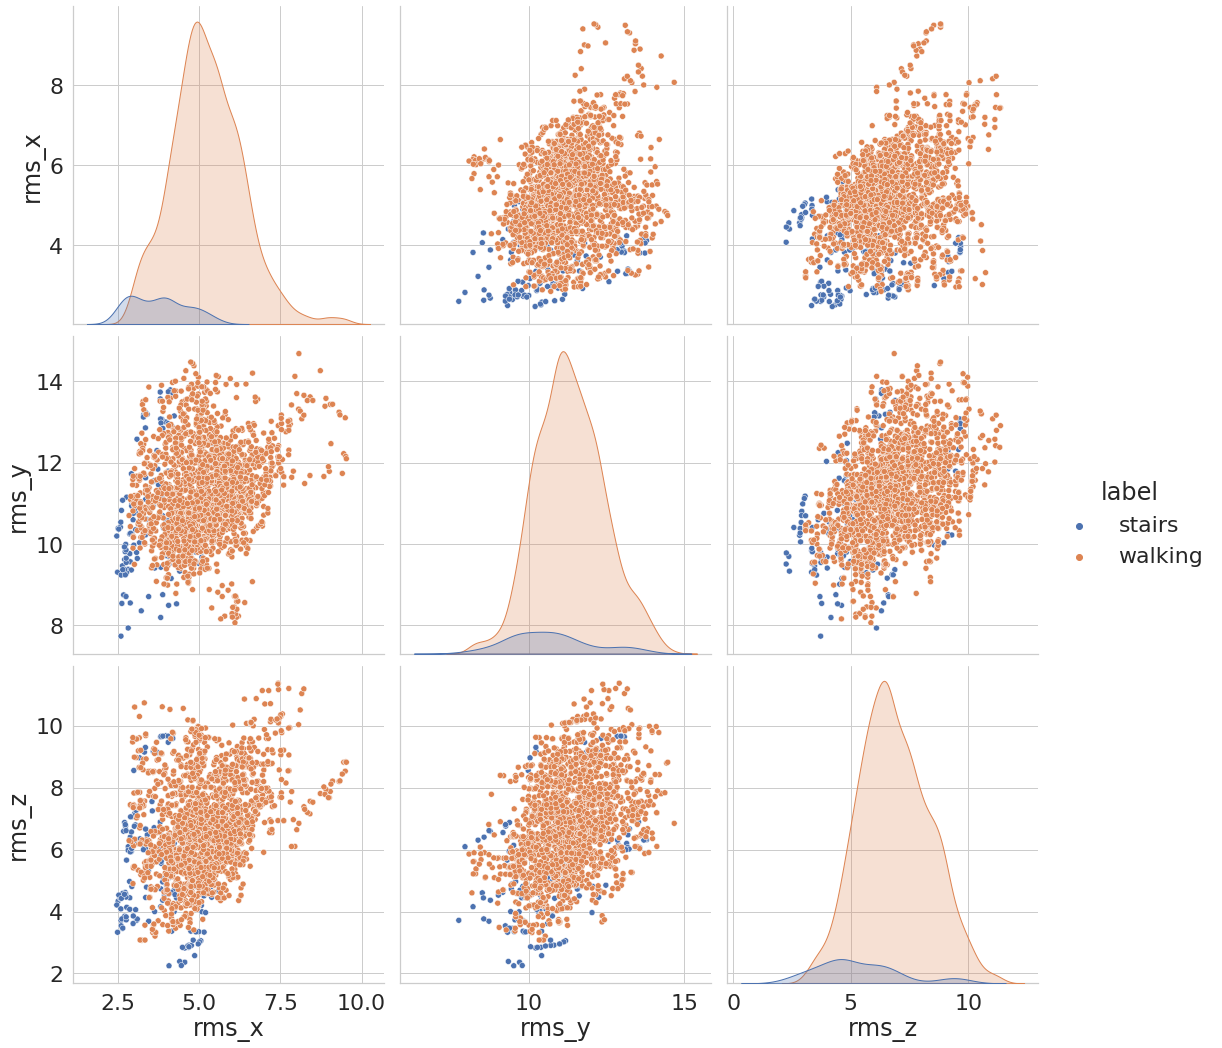

In [295]:
# plt.rcParams['figure.figsize'] = [16,8]
# plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
sns.pairplot(data=stairs_df[rms_features + ['label']], hue='label', height=5);

In [296]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[360  10]
 [  9  24]]
[[363   7]
 [  8  25]]
[[364   6]
 [ 12  21]]
[[366   4]
 [ 14  19]]
[[364   6]
 [ 13  20]]
F1 score mean: 0.71, std: 0.03


In [297]:
(y_valid != y_pred).sum()

19

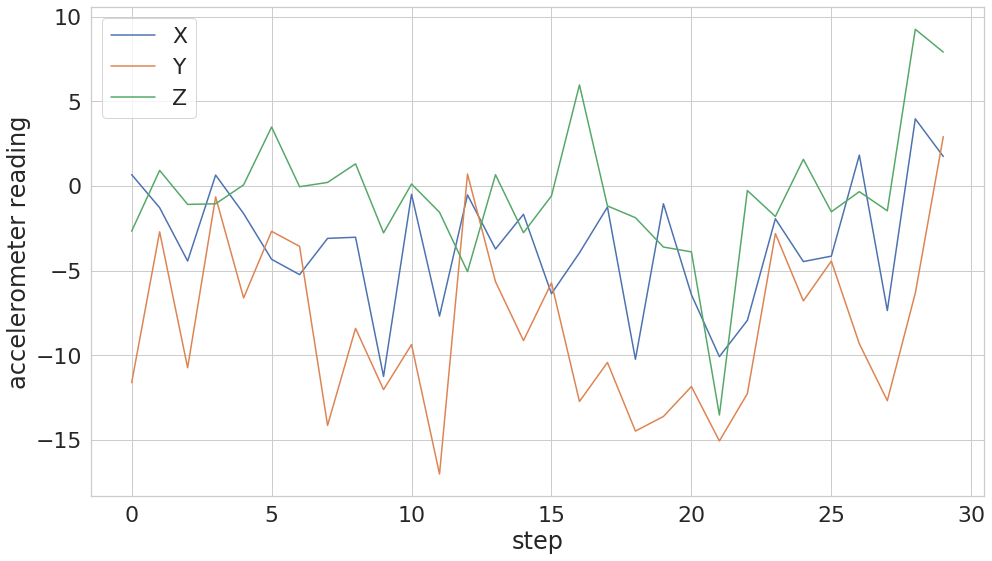

In [298]:
frame = raw_stairs_df.loc[0]
def plot_frame(frame, title=None):
    plt.figure(figsize=(16,9))
    sns.lineplot(y=frame[x_acc_cols].astype(float), x=np.arange(30), label='X')
    sns.lineplot(y=frame[y_acc_cols].astype(float), x=np.arange(30), label='Y')
    sns.lineplot(y=frame[z_acc_cols].astype(float), x=np.arange(30), label='Z').set_title(title)
    plt.ylabel('accelerometer reading')
    plt.xlabel('step')
    
plot_frame(frame)

In [299]:
misclassified_ix = y_valid[y_valid != y_pred].index
misclassified_ix, misclassified_ix.shape

(Int64Index([   2,    4,   17,   36,   90,  108,  117,  128,  143,  149,  150,
              158,  163,  213,  273,  793,  859, 1397, 1574],
            dtype='int64'),
 (19,))

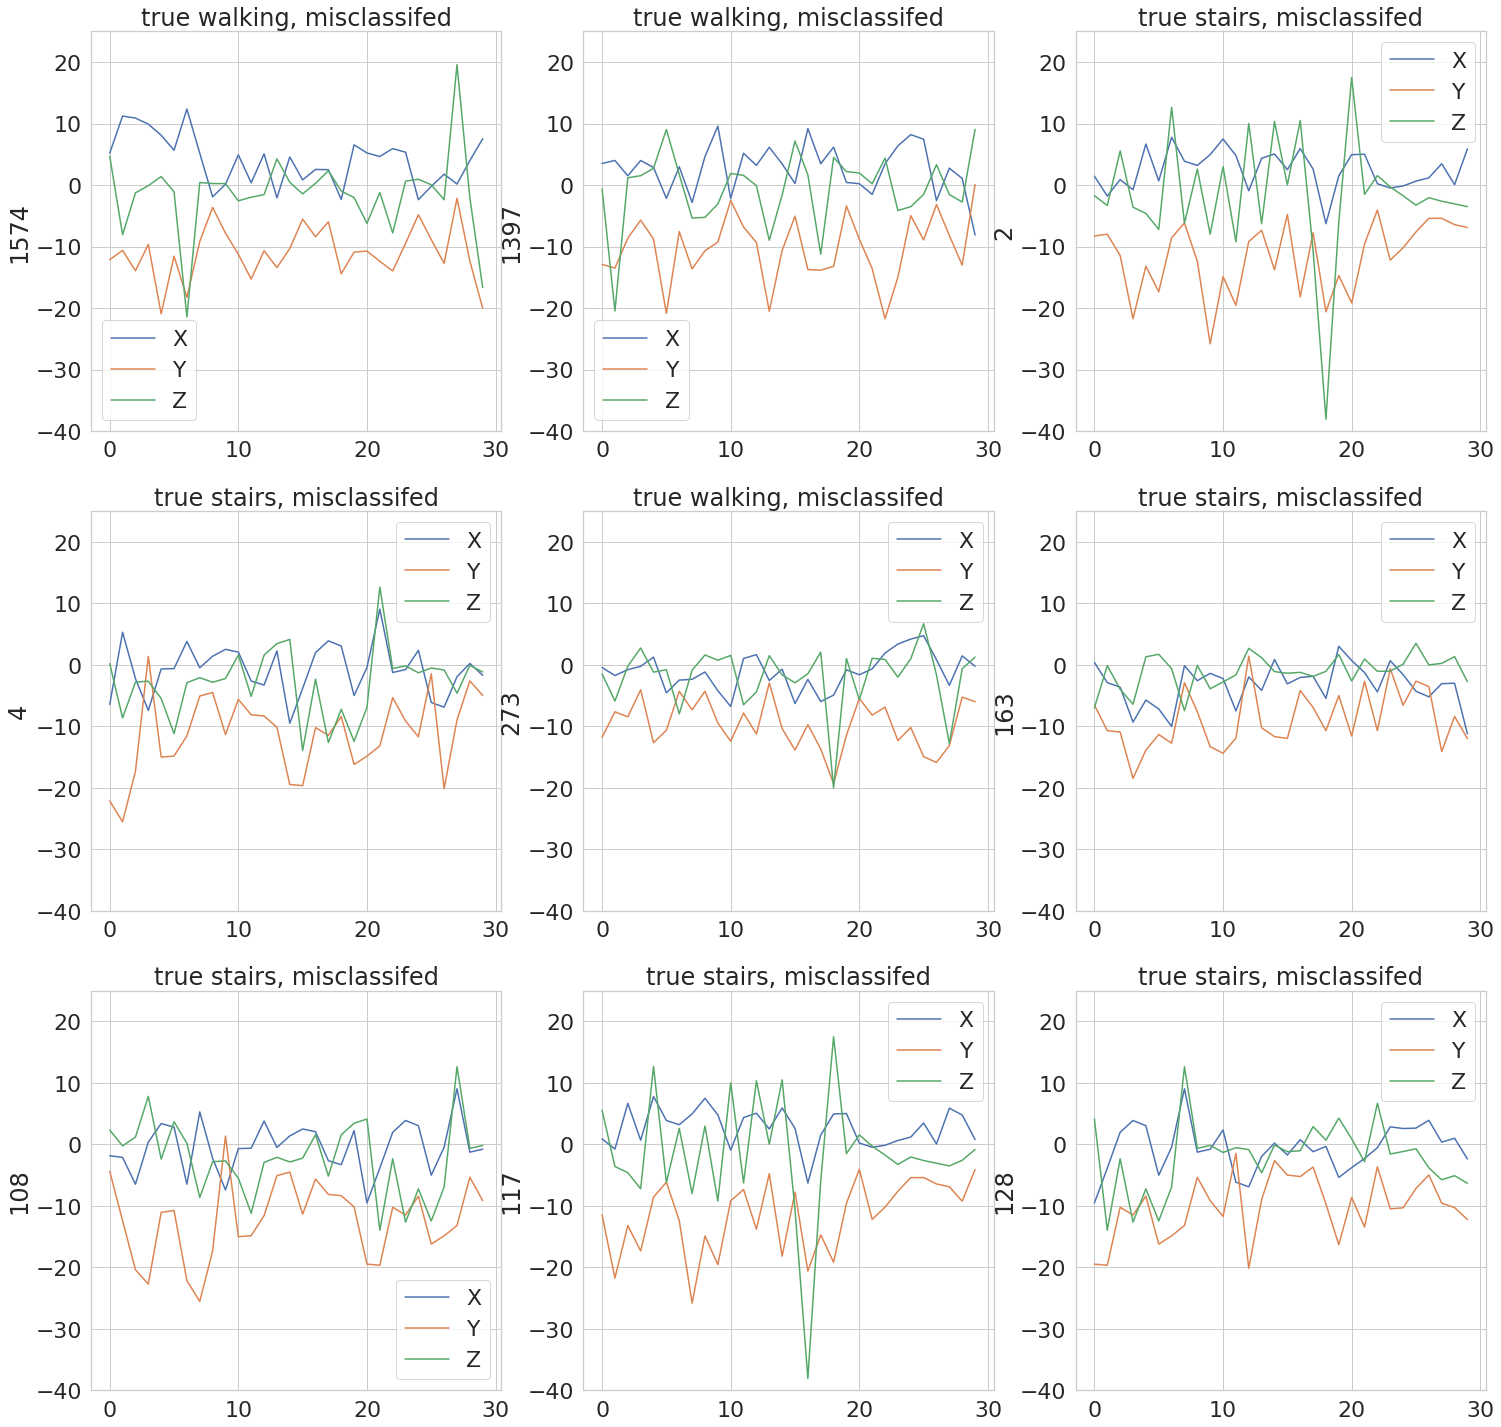

In [300]:
fig, axes = plt.subplots(3, 3, figsize=(25, 25))
axes = axes.flatten()

np.random.seed(1)
# misclassified_sample_ix = np.random.choice(misclassified_ix, size=9)
misclassified_sample_ix = np.array([1574, 1397, 2, 4, 273,163, 108,  117,  128,  143,  149,  150,])
for i, ax in enumerate(axes):
    frame = raw_stairs_df.loc[misclassified_sample_ix[i]]
    sns.lineplot(y=frame[x_acc_cols].astype(float), x=np.arange(30), label='X', ax=ax)
    sns.lineplot(y=frame[y_acc_cols].astype(float), x=np.arange(30), label='Y', ax=ax)
    sns.lineplot(y=frame[z_acc_cols].astype(float), x=np.arange(30), label='Z', ax=ax).set_title(f'true {frame.label}, misclassifed')
    ax.set_ylim(-40, 25)
# plt.ylim(-40, 25)

## corr

In [304]:
obs

acc_x_0     0.675165
acc_x_1      -1.2785
acc_x_2     -4.42448
acc_x_3     0.646435
acc_x_4     -1.62327
              ...   
acc_z_26     -0.3304
acc_z_27    -1.46046
acc_z_28     9.25598
acc_z_29     7.91044
label         stairs
Name: 0, Length: 91, dtype: object

In [ ]:
np.correlate

In [308]:
obs = raw_stairs_df.iloc[0]


(4030, 4030)

In [309]:
stairs_df['corr_xy'] = None

In [320]:
corr_matrix_xy = np.corrcoef(raw_stairs_df[x_acc_cols].astype('float64'), raw_stairs_df[y_acc_cols].astype('float64'))
corr_matrix_yz = np.corrcoef(raw_stairs_df[z_acc_cols].astype('float64'), raw_stairs_df[y_acc_cols].astype('float64'))
corr_matrix_xz = np.corrcoef(raw_stairs_df[x_acc_cols].astype('float64'), raw_stairs_df[z_acc_cols].astype('float64'))

In [321]:
ix = np.arange(len(stairs_df))
iy = ix + len(stairs_df)

In [322]:
stairs_df['corr_xy'] = corr_matrix_xy[ix, iy]
stairs_df['corr_yz'] = corr_matrix_yz[ix, iy]
stairs_df['corr_xz'] = corr_matrix_xz[ix, iy]

In [323]:
stairs_df['corr_xy']

0       0.518031
1      -0.455448
2      -0.026224
3       0.313036
4       0.037058
          ...   
2010    0.357598
2011    0.309853
2012   -0.094162
2013   -0.294859
2014    0.220485
Name: corr_xy, Length: 2015, dtype: float64

In [324]:
stairs_df['corr_xy'][42]

-0.13812277567617734

In [325]:
np.corrcoef(raw_stairs_df.iloc[0][x_acc_cols].astype('float64'), raw_stairs_df.iloc[0][y_acc_cols].astype('float64'))[0, 1], np.corrcoef(raw_stairs_df.iloc[42][x_acc_cols].astype('float64'), raw_stairs_df.iloc[42][y_acc_cols].astype('float64'))[0, 1]

(0.5180305700579393, -0.13812277567617734)

In [326]:
corr_features = ['corr_xy', 'corr_yz', 'corr_xz']

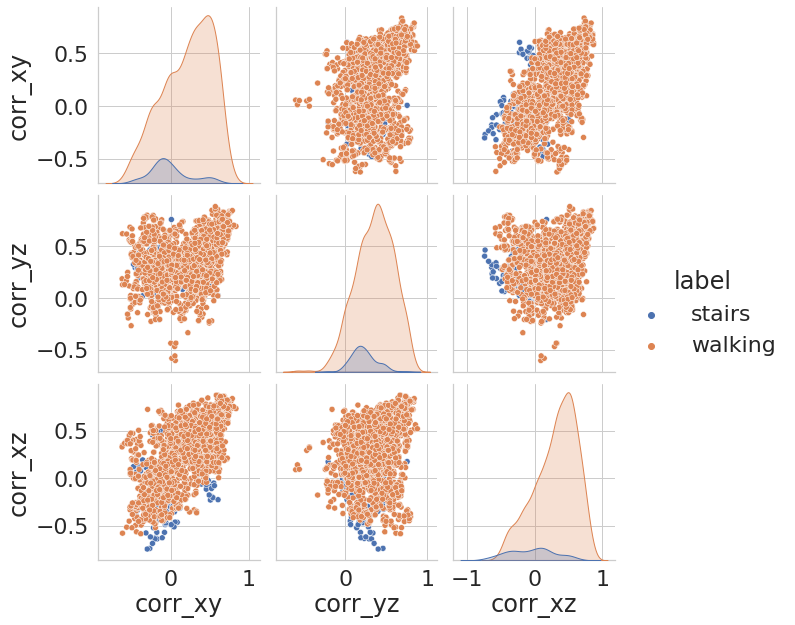

In [328]:
sns.pairplot(data=stairs_df[corr_features + ['label']], hue='label', height=3);

In [329]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features + corr_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[366   4]
 [  6  27]]
[[366   4]
 [  8  25]]
[[366   4]
 [ 11  22]]
[[369   1]
 [ 10  23]]
[[365   5]
 [  8  25]]
F1 score mean: 0.8, std: 0.03


In [333]:
from sklearn.ensemble import RandomForestClassifier

In [334]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features + corr_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[370   0]
 [  3  30]]
[[370   0]
 [  2  31]]
[[370   0]
 [  5  28]]
[[370   0]
 [  4  29]]
[[370   0]
 [  3  30]]
F1 score mean: 0.95, std: 0.02


In [335]:
len(mean_features + minmax_range_features + std_features + rms_features + corr_features)

15

In [363]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


In [351]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features + corr_features]
y = stairs_df['is_stairs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8095238095238095
[[555  10]
 [  6  34]]


In [364]:
feature_names = mean_features + minmax_range_features + std_features + rms_features + corr_features
class_names=['walking', 'stairs']

In [366]:
!pip install graphviz

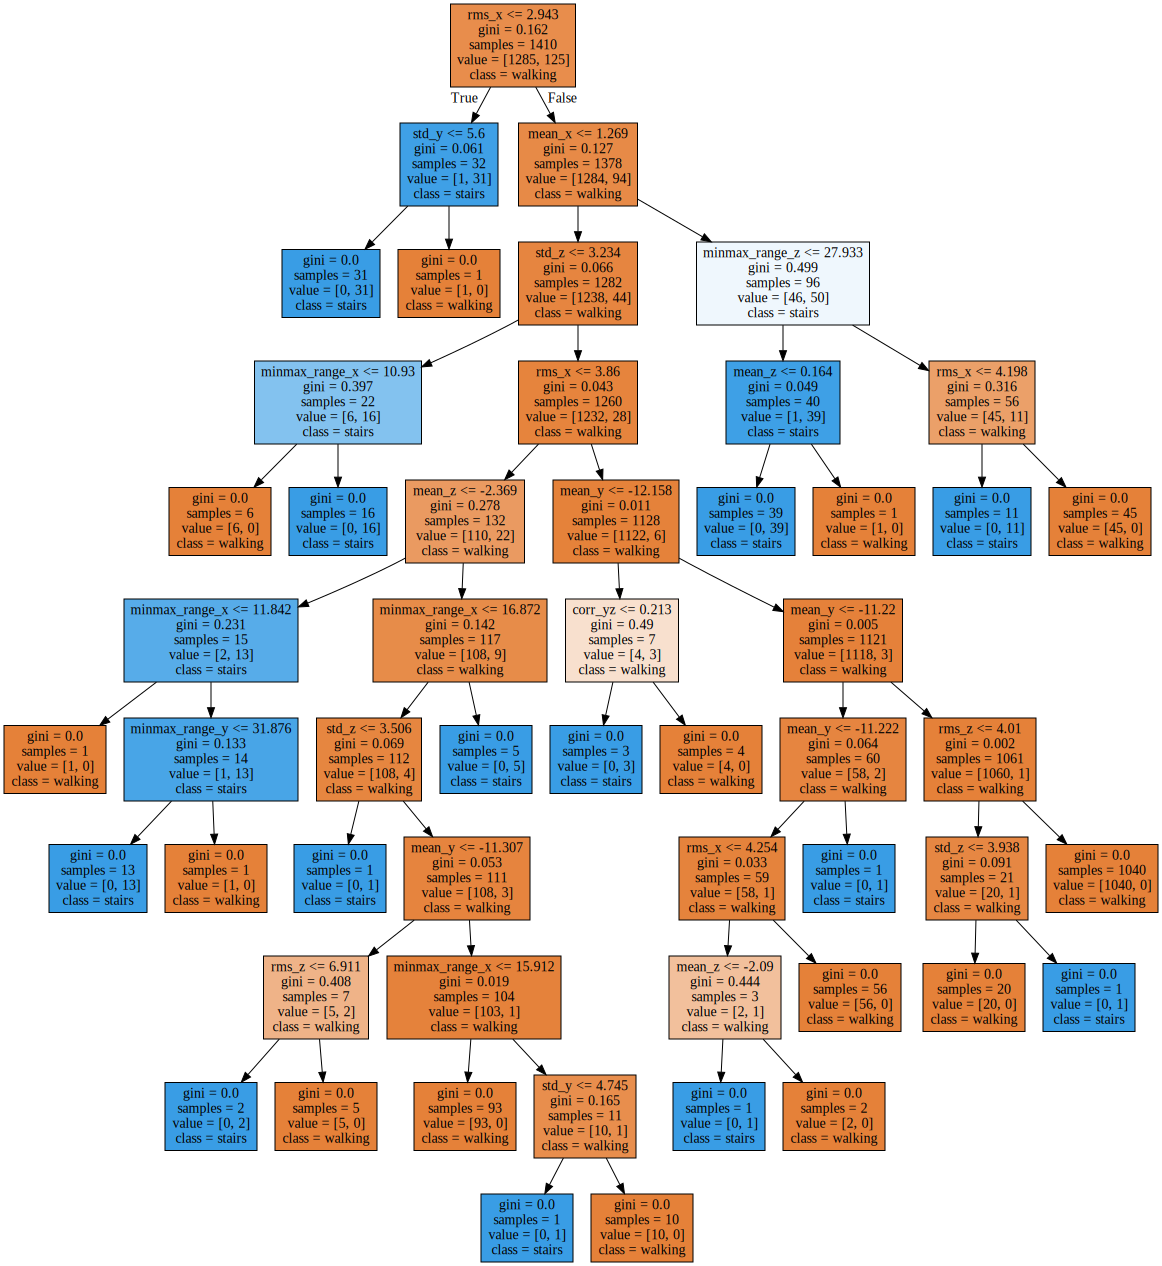

In [369]:
import graphviz
# DOT data
dot_data = export_graphviz(cls, out_file=None, 
                                feature_names=feature_names,  
                                class_names=class_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

## n peaks

In [202]:
from scipy.signal import find_peaks

In [211]:
def count_peask(ts):
    peaks, _ = find_peaks(ts)
    return len(peaks)


In [212]:
count_peask(raw_data[x_acc_cols].iloc[0])

11

In [214]:
feature_df['n_peaks'] = raw_data[x_acc_cols].apply(count_peask, axis=1)

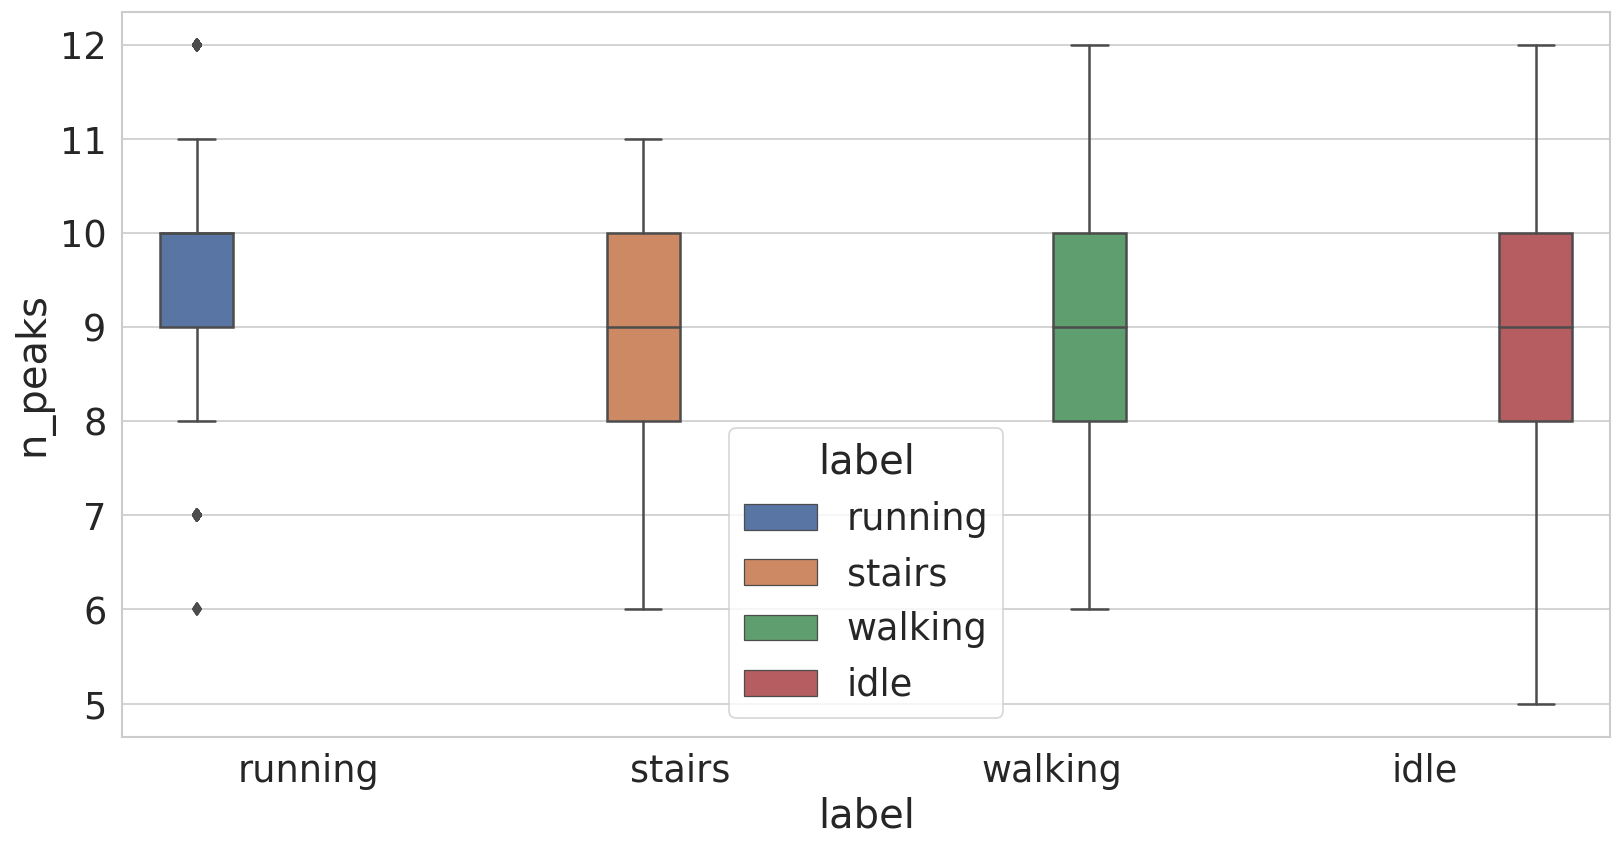

In [216]:
sns.boxplot(data=feature_df, x='label', y='n_peaks', hue="label",)

List of features:

1. Mean on every axis
2. average of peak frequency